# Sort spikes and make rasters

For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import json

import numpy as np
import pandas as pd

from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt

from importlib import reload
from multiprocessing import Process


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)



os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'
N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

if 'pakhi' in socket.gethostname():
    os.environ["KILOSORT3_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'

if 'pouli' in socket.gethostname():
    os.environ["KILOSORT3_PATH"] = '/home/pouli/repos/Kilosort'

2022-05-03 00:47:54,730 root         INFO     Running on pakhi


In [2]:
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import sglxsync as sy
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2022-05-03 00:47:56,307 root         INFO     all modules loaded


### Session parameters and raw files

MAKE SURE THESE PARAMETERS, SPECIALLY on_signal, trial_tag_chan coincide with those used when running pre_processing.
Also TODO: port those parameters/check consistency

In [7]:
reload(et)

bird = 's_b1555_22'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [8]:
reload(et)

sess_par = {'bird': bird,
           'sess': '2022-04-29',
           'probe': 'probe_0',
           'sort': 'sort_0',
           'trial_tag_chan': 0, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': '2022-04-29'}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [9]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx'

In [10]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2022-05-03 00:50:06,195 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx', 'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-04-29', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-04-29', 'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/sort_0'}, 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/rig.json', 'kwd': '/scratch/

['0644_g0', '1055_g0', '1530_g0', '2234_stim_g0']

In [11]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[3] 
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [12]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2234_stim_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/2234_stim_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0',
  'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-04-29/2234_stim_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0',
  'tmp': '/scratch/earneodo/tmp/2234_stim_g0',
  'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-04-29/2234_stim_g0',
  'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/2234_stim_g0/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0/sort_0'},
 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/2234_stim_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/settings.isf',
  'r

In [13]:
sgl_folders

{'nidq': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0',
 'imec_0': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0/2234_stim_g0_imec0'}

In [14]:
sgl_files

{'nidq': ['/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0/2234_stim_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0/2234_stim_g0_imec0/2234_stim_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0/2234_stim_g0_imec0/2234_stim_g0_t0.imec0.ap.meta']}

In [15]:
files_pd = pd.DataFrame(sgl_files)

### load epoch files

In [16]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}

mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
#probe_data_folder = sgl_folder['imec'][probe_id]


In [17]:
run_recordings

{'nidq': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f986d108610>,
 'lf_0': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f98ac6f1100>,
 'ap_0': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f98ac67daf0>}

### Sync signals
(starts in a process, will let know when done. The idea is that it can run while spike sorting, if its long)

In [18]:
# all the streams are the ones in the recording_extractors from the raw data, plus the ones generated in sglx_preprocess
all_streams = list(run_recordings.keys()) + ['wav']

#all_streams = ['lf_0', 'ap_0', 'nidq']
#all_streams = ['ap_0', 'wav']
all_syn_dict = {k: sy.get_syn_pattern(run_recordings, exp_struct, k, force=False) for k in all_streams[:]}

sync_p = Process(target=sy.sync_all, args=(all_syn_dict, sess_par['ref_stream']), 
                 kwargs={'force': False}
                )
sync_p.start()

2022-05-03 00:50:32,873 ceciestunepipe.util.sglxsync INFO     getting syn patterns for nidq
2022-05-03 00:50:32,895 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0/nidq_sync_dict.pkl
2022-05-03 00:50:32,901 ceciestunepipe.util.sglxsync INFO     getting syn patterns for lf_0
2022-05-03 00:50:32,902 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0/lf_0_sync_dict.pkl
2022-05-03 00:50:32,913 ceciestunepipe.util.sglxsync INFO     getting syn patterns for ap_0
2022-05-03 00:50:32,914 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0/ap_0_sync_dict.pkl
2022-05-03 00:50:32,918 ceciestunepipe.util.sglxsync INFO     getting syn patterns for wav
2022-05-03 00:50:32,919 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/

## The sorting

- invoke the recording extractor where the probe is
- quickly check data (chans look ok?)
- set parameters
- use the recording extractor and the function to sort with kilosort
- ALTERNATIVELY: do the manual curation
- Load the spikes using the functions from ceciestunepipe

##### pick one ap stream, view it after running some of the toolkits

###### view it raw

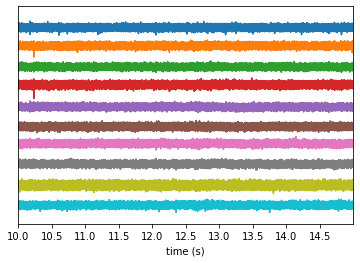

In [19]:
sw.plot_timeseries(run_recordings['ap_0'], channel_ids=range(250, 260), trange=[10,15])

###### filtered

In [20]:
# ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
# sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 50), trange=[10,15])

###### cmr

In [21]:
# ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
# sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(45, 55), trange=[10,15])

In [22]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2234_stim_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/2234_stim_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0',
 'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-04-29/2234_stim_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0',
 'tmp': '/scratch/earneodo/tmp/2234_stim_g0',
 'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-04-29/2234_stim_g0',
 'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/2234_stim_g0/sort_0',
 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0/sort_0'}

In [23]:
ss.__version__

'0.4.5'

In [24]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [25]:
default_ks3_params = ss.Kilosort3Sorter.default_params()
default_ks3_params

{'detect_threshold': 6,
 'projection_threshold': [9, 9],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.2,
 'minfr_goodchannels': 0.2,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 300,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500}

##### manually enter ksort params

In [26]:
ks_params = {'minFR': 0.001,
             'minfr_goodchannels': 0.001}

In [27]:
tmp_loc = exp_struct['folders']['ksort']
tmp_loc

'/scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/2234_stim_g0/sort_0'

#### run the spike sort

In [28]:
reload(ks)

<module 'ceciestunepipe.util.spike.kilosort' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py'>

In [29]:
## 
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle')
def do_sort():
    return ks.run_spikesort(run_recordings['ap_0'], logger, sort_pickle_path, tmp_loc, restrict_to_gpu=0, 
                     sorting_method='kilosort3', chunk_mb=16834, force_redo=False,
                     **ks_params)

sort_p = Process(target=do_sort)
sort_p.start()

2022-05-03 00:55:29,595 root         INFO     Grouping property: None
2022-05-03 00:55:29,635 root         INFO     sorting method: kilosort3
2022-05-03 00:55:29,636 root         INFO     Will set visible gpu devices 0
2022-05-03 00:55:29,637 root         INFO     Sorting tmp dir /scratch/earneodo/s_b1555_22/sglx/ksort/2022-04-29/2234_stim_g0/sort_0/tmp_ks3
2022-05-03 00:55:29,638 root         INFO     Previous sort not found, sorting
Writing to binary .dat file: 100%|##########| 16/16 [15:12<00:00, 57.05s/it]


kilosort3 run time 11200.70s


Process Process-2:
Traceback (most recent call last):
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-29-6e799392020b>", line 4, in do_sort
    return ks.run_spikesort(run_recordings['ap_0'], logger, sort_pickle_path, tmp_loc, restrict_to_gpu=0,
  File "/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py", line 170, in run_spikesort
    sort = ss.run_kilosort3(
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/spikesorters/sorterlist.py", line 527, in run_kilosort3
    return run_sorter('kilosort3', *args, **kwargs)
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/spikesorters/sorterlist.py", line 94, in run_sorter
    sortingextractor = sorter.get_result(raise_

### interlude: process the auditory stimuli

In [30]:
def load_stim_tags_dict(bout_stim_sess: str) -> dict:
    sess_exp_struct = et.get_exp_struct(sess_par['bird'], bout_stim_sess)
    sess_derived_folder = os.path.split(sess_exp_struct['folders']['derived'])[0]

    stim_tags_path = os.path.join(sess_derived_folder, 'bout_stim', 'sbc_stim', 'stim_tags.json')
    with open(stim_tags_path, 'rb') as f:
        stim_tags_dict = json.load(f)

    return stim_tags_dict

#### get the stimulus onset/offset files and the whole sine wave syncrhoniation channel
- setup the name of the arrays (in the derived data), generated in the sglx_preprocess notebook
    - wav_stim_syn_sine_ttl: array of registered ttl events (onset/offset) detected from the sine wave channel accompanying the stimulus
    - wav_stim.npy: array with the sinewave sampled at the original sampling rate (nidq)
    
- get the 

In [33]:
reload(su)
## get the events npy file

# event_name
event_name = 'wav_stim'

ttl_ev_name = event_name + '_sync_sine_ttl' ## syn_ttl comes from the digital pin, syn_sine_ttl from the sine
stream_name = event_name

npy_stim_path = os.path.join(exp_struct['folders']['derived'], ttl_ev_name + '_evt.npy')
stream_stim_path = os.path.join(exp_struct['folders']['derived'], stream_name + '.npy')

trial_ttl = np.load(npy_stim_path)
trial_stream = np.load(stream_stim_path, mmap_mode='r')

stim_s_f = int(all_syn_dict['nidq']['s_f'])
### load the stimulus name: frequency tag dictionary
stim_tags_dict = load_stim_tags_dict(sess_par['stim_sess'])

trial_tagged_pd = su.get_trials_pd(trial_ttl, trial_stream, stim_s_f, 
                            on_signal=sess_par['on_signal'], 
                            tag_chan=sess_par['trial_tag_chan'],
                           stim_tags_dict=stim_tags_dict, trial_is_onof=True)

2022-05-03 01:34:15,357 ceciestunepipe.util.stimutil INFO     Looking for precise star/end of 177.0 stimulus trials
2022-05-03 01:34:15,358 ceciestunepipe.util.stimutil INFO     forward pass (onsets)
2022-05-03 01:34:57,247 ceciestunepipe.util.stimutil INFO     reverse pass (offsets)
2022-05-03 01:34:59,374 ceciestunepipe.util.stimutil INFO     Entered a stim/frequency tag dictionary, will match and get the stim names onto the trials pandas dataframe


In [34]:
trial_tagged_pd

,start,end,tag_freq_int,tag_freq,stim_name
0,2858642,3647995,3007,3000,b1555_08-00-01-01_438012
1,3970015,5419995,1992,2000,b1555_08-00-01-01_1407581
2,5709222,7535982,1484,1500,b1238_17-00-01-01_542947
3,7817194,9095998,1015,1000,b1238_16-00-01-01_10697911_rev
4,9404144,10683988,1015,1000,b1238_16-00-01-01_10697911_rev
...,...,...,...,...,...
172,284241355,285027988,3007,3000,b1555_08-00-01-01_438012
173,285287362,286555997,3515,3500,b1555_11-00-01-02_183134
174,286881912,288331992,1992,2000,b1555_08-00-01-01_1407581
175,288612959,290275996,2499,2500,b1555_08-00-01-01_2531288


#### load the sync
(running sync_all with force=False, it should load whatever computed in the process it ran above.)

In [35]:
sy.sync_all(all_syn_dict, sess_par['ref_stream'], force=False)

2022-05-03 01:35:25,732 ceciestunepipe.util.sglxsync INFO     syncing all times to ap_0
2022-05-03 01:35:25,734 ceciestunepipe.util.sglxsync INFO      synch nidq...
2022-05-03 01:35:25,799 ceciestunepipe.util.sglxsync INFO      synch lf_0...
2022-05-03 01:35:25,862 ceciestunepipe.util.sglxsync INFO      synch wav...
2022-05-03 01:35:25,927 ceciestunepipe.util.sglxsync INFO     Done with sync_all


##### sync all the trial timestams to the spike time base (ap_0 from the imec data)

In [36]:
reload(sy)
trial_dict, trial_syn_pd = sy.trial_syn_from_pd(trial_tagged_pd, all_syn_dict, s_f_key='nidq')

In [37]:
trial_syn_pd.head()

,start,end,tag_freq_int,tag_freq,stim_name,start_ms,len_ms,start_ms_ap_0,start_sample_ap_0,start_sample_naive,start_sample_nidq
0,2858642,3647995,3007,3000,b1555_08-00-01-01_438012,71467.116039,19734.119364,71468.218570,2144050,2858642,2858642
1,3970015,5419995,1992,2000,b1555_08-00-01-01_1407581,99251.855489,36250.040723,99253.381850,2977607,3970015,3970015
2,5709222,7535982,1484,1500,b1238_17-00-01-01_542947,142732.679071,45669.681231,142734.859276,4282053,5709221,5709222
3,7817194,9095998,1015,1000,b1238_16-00-01-01_10697911_rev,195432.765171,31970.576889,195435.718410,5863081,7817193,7817194
4,9404144,10683988,1015,1000,b1238_16-00-01-01_10697911_rev,235107.106973,31996.577277,235110.657258,7053331,9404144,9404144


### Save the bout/mot/trial data

In [38]:
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'stim_dict_ap0.pkl')
bout_pd_path = os.path.join(exp_struct['folders']['derived'], 'stim_pd_ap0.pkl')

with open(bout_dict_path, 'wb') as handle:
    pickle.dump(trial_dict, handle)
    
trial_syn_pd.to_pickle(bout_pd_path)

logger.info('saved syncronized bout dict and pandas dataframe to {}, {}'.format(bout_dict_path, bout_pd_path))

2022-05-03 01:46:59,716 root         INFO     saved syncronized bout dict and pandas dataframe to /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0/stim_dict_ap0.pkl, /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-04-29/sglx/2234_stim_g0/stim_pd_ap0.pkl


### load the previously computed bout/mot/trial files

In [39]:
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'stim_dict_ap0.pkl')
bout_pd_path = os.path.join(exp_struct['folders']['derived'], 'stim_pd_ap0.pkl')

with open(bout_dict_path, 'rb') as handle:
    trial_dict = pickle.load(handle)
    
trial_syn_pd = pd.read_pickle(bout_pd_path)

#### load the sort

In [40]:
reload(ks)
clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3'))
spk_df.head(1)

,times,clusters,cluster_id
0,138,374,374


In [41]:
clu_df.head(1)

,cluster_id,KSLabel,group,MSLabel,has_template,template,max_chans,main_chan,main_7,main_wav_7
0,0,good,good,None,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[5, 3, 4, 7, 2, 1, 0, 6, 9, 8, 11, 13, 12, 15,...",5,"[0, 1, 2, 3, 4, 5, 7]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."


In [42]:
# count the good ones
np.unique(clu_df[clu_df['KSLabel']=='good']['cluster_id']).size

399

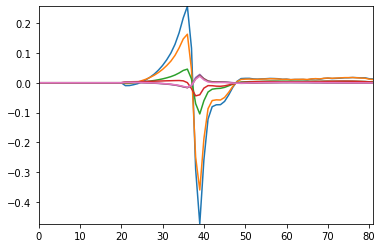

In [43]:
plt.plot(clu_df.loc[65, 'main_wav_7']);

\### Visualize a bout together with the neural traces

In [44]:
plt.rcParams['lines.linewidth'] = 0.1

In [45]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [46]:
s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])

In [47]:
ap_sf = all_syn_dict['ap_0']['s_f']

### one example of bout onset

In [50]:
## call the HVC/RA sites
ra_chans = range(80, 200)
neur_chans = ra_chans

clu_df['nucleus'] = np.nan
#clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'
#clu_df.loc[clu_df['main_chan'].isin(neur_chans), 'nucleus'] = 'ncm'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])

In [52]:
neur_chans = ra_chans


In [53]:
mot_idx = 15

mot_start_wav = trial_dict['start_sample_wav'][mot_idx]
mot_start_ap = trial_dict['start_sample_ap_0'][mot_idx]

pre_sec = -2.25
post_sec = 25 - pre_sec

ap_sf = all_syn_dict['ap_0']['s_f']

mic_arr = mic_stream[mot_start_wav + int(pre_sec*s_f_wav): mot_start_wav + int(post_sec*s_f_wav)]

ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=neur_chans, 
                                            start_frame=mot_start_ap + int(pre_sec*ap_sf), 
                                            end_frame=mot_start_ap + int((post_sec*ap_sf)))

<ipython-input-54-12a952a9720b>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])


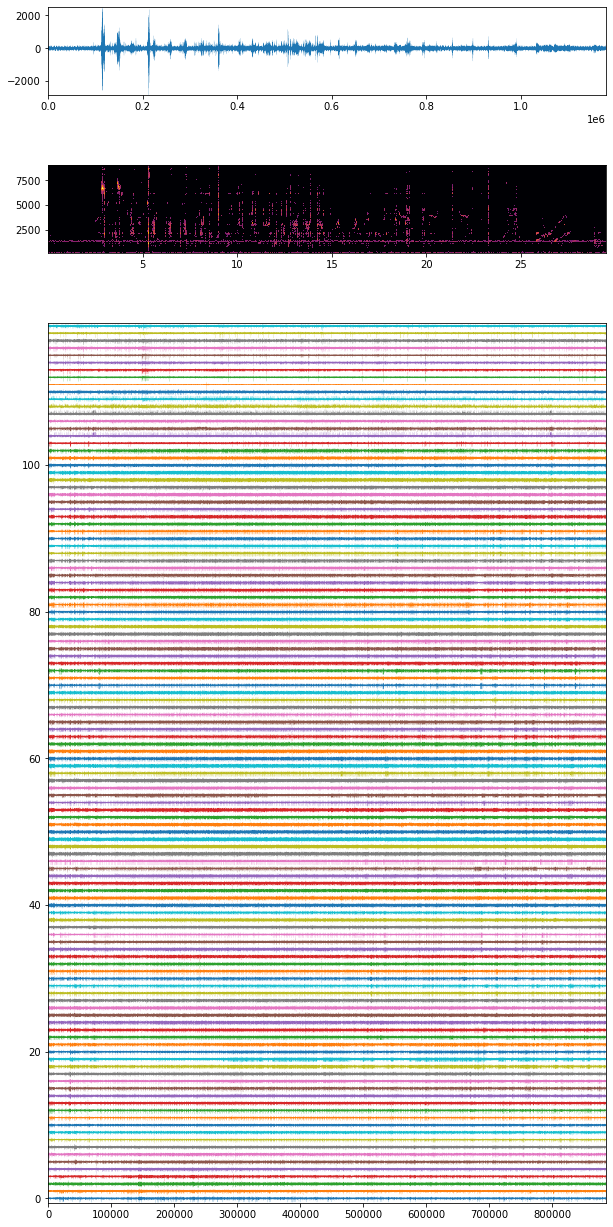

In [54]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_wav)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])

#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

In [55]:
## get the actural raster for some clusters
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

t_pre = - 2
t_post = 2

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


bout_idx = mot_idx
start_ap = trial_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
end_ap = trial_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_nidq = trial_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_nidq = trial_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)
    

spk_arr = ks.get_window_spikes(spk_df, clu_list, start_ap , end_ap)


#rast_arr = ks.get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:99: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [56]:
clu_list.size

138

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


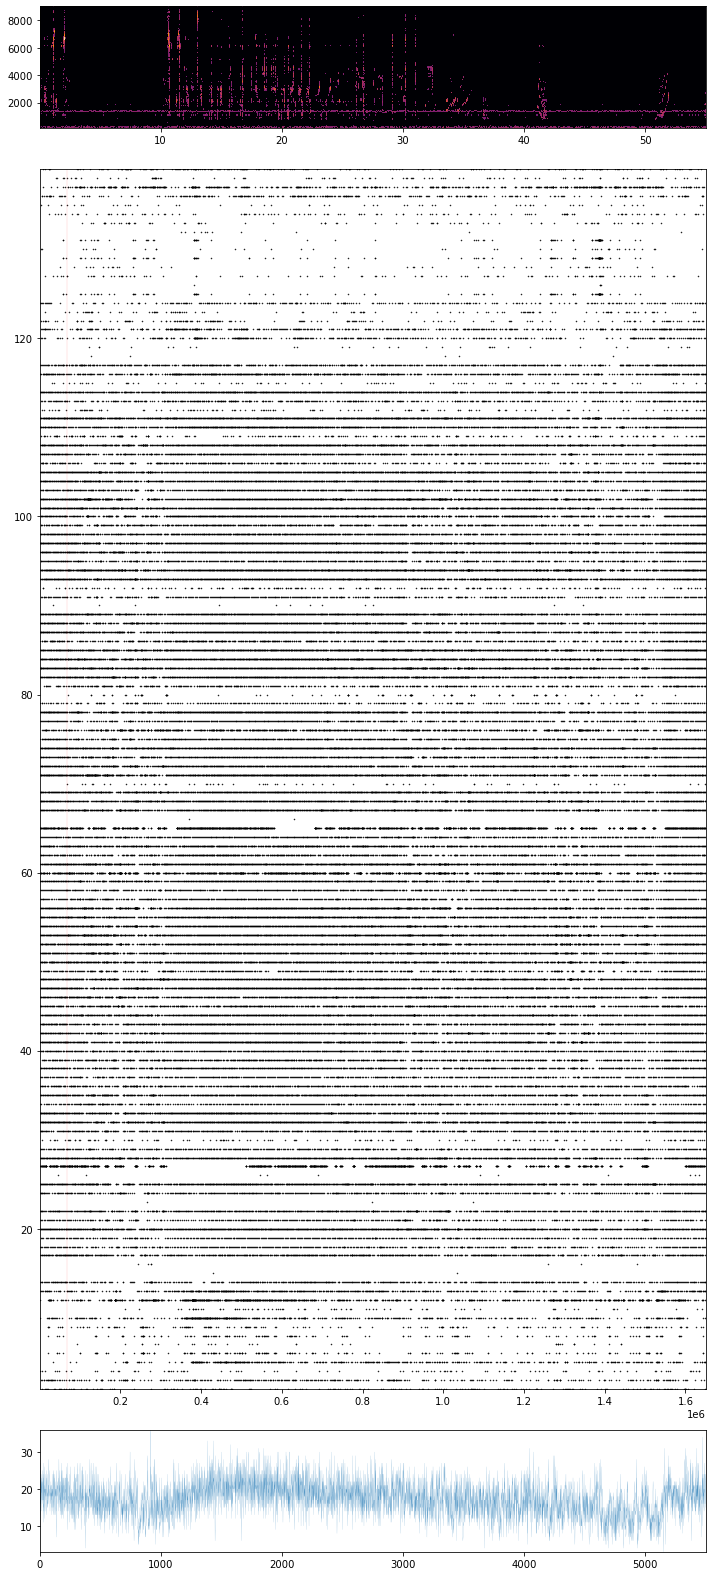

In [57]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 10
t_post = 45

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = mot_idx
start_ap = trial_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = trial_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = trial_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = trial_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = ks.get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [85]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_sua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

### save cluster and cluster metadata

In [58]:
clu_df['nucleus'] = np.nan
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'

sort_folder = os.path.join(exp_struct['folders']['derived'], sess_par['sort'])
os.makedirs(sort_folder, mode=0o777, exist_ok=True)

clu_df_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(sort_folder, 'spk_df.pickle')
spk_df.to_pickle(spk_df_path)

### plot rasters by stimulus

In [59]:
trial_syn_pd.head()

,start,end,tag_freq_int,tag_freq,stim_name,start_ms,len_ms,start_ms_ap_0,start_sample_ap_0,start_sample_naive,start_sample_nidq
0,2858642,3647995,3007,3000,b1555_08-00-01-01_438012,71467.116039,19734.119364,71468.218570,2144050,2858642,2858642
1,3970015,5419995,1992,2000,b1555_08-00-01-01_1407581,99251.855489,36250.040723,99253.381850,2977607,3970015,3970015
2,5709222,7535982,1484,1500,b1238_17-00-01-01_542947,142732.679071,45669.681231,142734.859276,4282053,5709221,5709222
3,7817194,9095998,1015,1000,b1238_16-00-01-01_10697911_rev,195432.765171,31970.576889,195435.718410,5863081,7817193,7817194
4,9404144,10683988,1015,1000,b1238_16-00-01-01_10697911_rev,235107.106973,31996.577277,235110.657258,7053331,9404144,9404144


In [60]:
### list the unique stimuli
stim_names_arr = np.unique(trial_syn_pd['stim_name'])
stim_names_arr

array(['b1238_16-00-01-01_10697911', 'b1238_16-00-01-01_10697911_rev',
       'b1238_17-00-01-01_542947', 'b1555_08-00-01-01_1407581',
       'b1555_08-00-01-01_2531288', 'b1555_08-00-01-01_438012',
       'b1555_11-00-01-02_183134'], dtype=object)

### pick a stim and get the array of rasters for that stim

In [81]:
nuclei_list = ['ra']
stim_name = stim_names_arr[5]

trial_select = (trial_syn_pd['stim_name'] == stim_name)

start_sample_ap_arr = trial_syn_pd.loc[trial_select, 'start_sample_ap_0'].values

len_trial = int(np.max(trial_syn_pd.loc[trial_select, 'len_ms']) * all_syn_dict['ap_0']['s_f'] * 0.001)

clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])

In [82]:
len_trial

592324

In [83]:
rast_arr = ks.get_rasters(spk_df, clu_list, start_sample_ap_arr + t_pre_samp, len_trial - 2*t_pre_samp)

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:99: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [84]:
rast_arr.shape[1]/20000

59.6162

In [85]:
rast_arr.shape

(138, 1192324, 25)

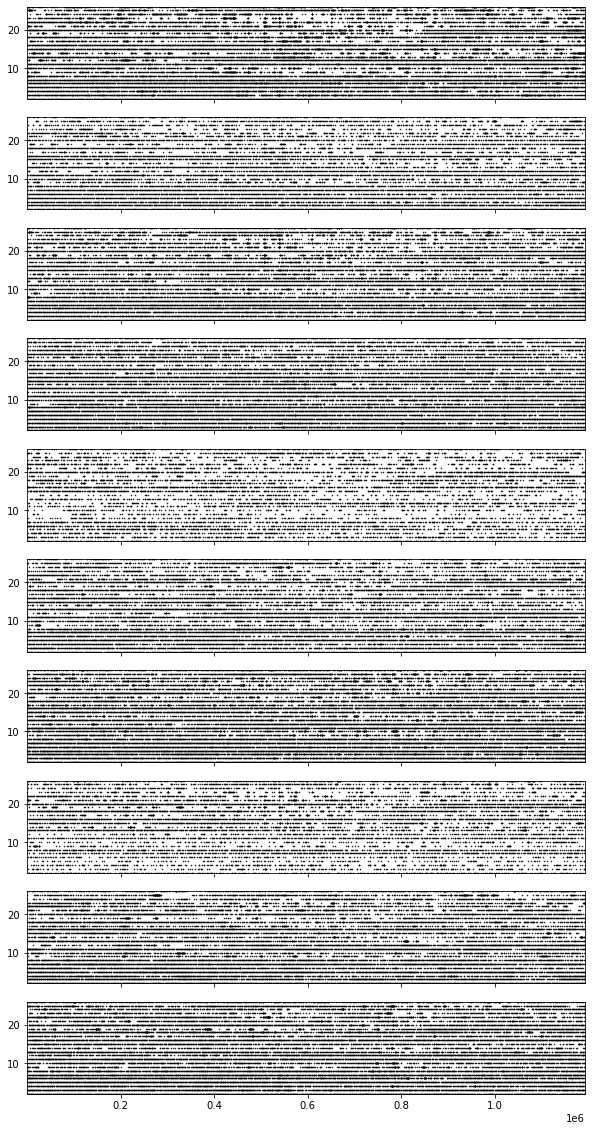

In [90]:
reload(pu)

fig, ax_arr = plt.subplots(nrows=10, figsize=[10, 20], sharex=True)

for i_rast, clu_idx in enumerate(range(100, 110)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    pu.plot_as_raster(rast_arr[clu_idx].T, t_0=-t_pre_samp, t_f=len_trial - t_pre_samp, 
                      ax=ax_arr[i_rast])

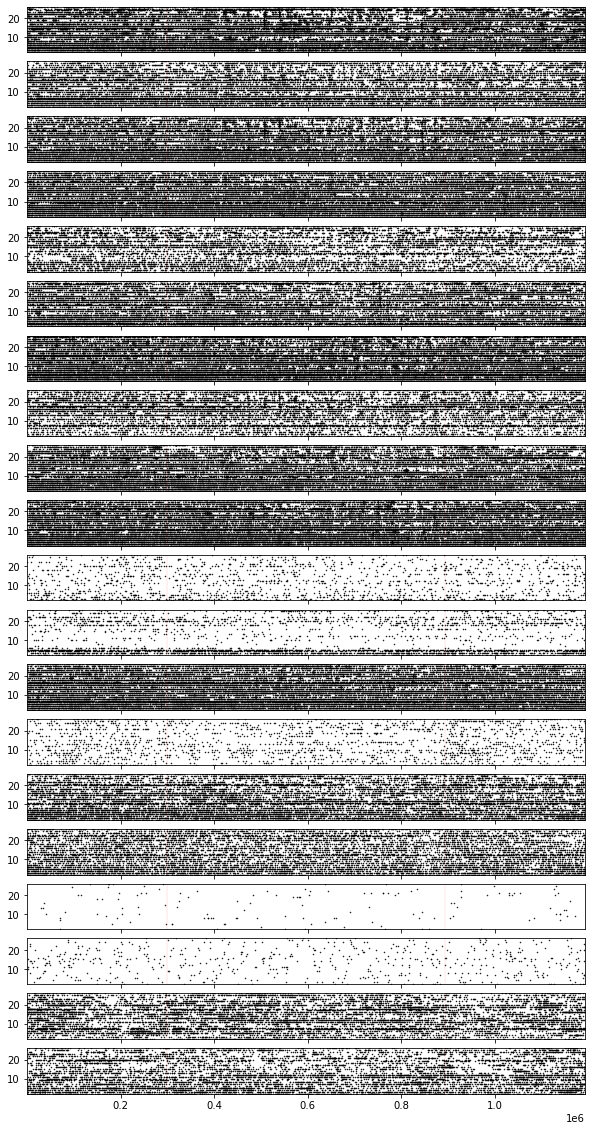

In [88]:
fig, ax_arr = plt.subplots(nrows=20, figsize=[10, 20], sharex=True)

for i_rast, clu_idx in enumerate(range(100, 120)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    pu.plot_as_raster(rast_arr[clu_idx].T, t_0=-t_pre_samp, t_f=len_trial - t_pre_samp, ax=ax_arr[i_rast])

In [75]:
trial_syn_pd

,start,end,tag_freq_int,tag_freq,stim_name,start_ms,len_ms,start_ms_ap_0,start_sample_ap_0,start_sample_naive,start_sample_nidq
0,2858642,3647995,3007,3000,b1555_08-00-01-01_438012,7.146712e+04,19734.119364,7.146822e+04,2144050,2858642,2858642
1,3970015,5419995,1992,2000,b1555_08-00-01-01_1407581,9.925186e+04,36250.040723,9.925338e+04,2977607,3970015,3970015
2,5709222,7535982,1484,1500,b1238_17-00-01-01_542947,1.427327e+05,45669.681231,1.427349e+05,4282053,5709221,5709222
3,7817194,9095998,1015,1000,b1238_16-00-01-01_10697911_rev,1.954328e+05,31970.576889,1.954357e+05,5863081,7817193,7817194
4,9404144,10683988,1015,1000,b1238_16-00-01-01_10697911_rev,2.351071e+05,31996.577277,2.351107e+05,7053331,9404144,9404144
...,...,...,...,...,...,...,...,...,...,...,...
172,284241355,285027988,3007,3000,b1555_08-00-01-01_438012,7.106140e+06,19666.118349,7.106246e+06,213187711,284241355,284241355
173,285287362,286555997,3515,3500,b1555_11-00-01-02_183134,7.132290e+06,31716.348097,7.132397e+06,213972241,285287362,285287362
174,286881912,288331992,1992,2000,b1555_08-00-01-01_1407581,7.172155e+06,36252.540761,7.172262e+06,215168191,286881912,286881912
175,288612959,290275996,2499,2500,b1555_08-00-01-01_2531288,7.215432e+06,41576.545176,7.215539e+06,216466517,288612959,288612959


### Now done this, this notebooks has generated:

- Spike sorted data:
    (with quality of sort (be auto or manually in 'MSlabel/KSlabel'))
    clu_df.pickle and spk_df.pickle in 
    /mnt/sphere/speech_bci/derived_data/bird/sess/sglx/epoch/sort_id
    
- Stimulus data:
    stim_pd_ap0.pkl and stim_dict_ap0.pkl
    /mnt/sphere/speech_bci/derived_data/bird/sess/sglx/epoch/
    
    

In [402]:
from IPython.display import Markdown as md

In [407]:
md('The spike sorted data was saved to {}'.format(sort_folder))

The spike sorted data was saved to /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0153_g0/sort_0

In [408]:
md('The stimulus data was saved to {}'.format(bout_pd_path))

The stimulus data was saved to /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0153_g0/stim_pd_ap0.pkl